In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools

# Load Data

In [7]:
# Daten laden
data = pd.read_csv('data_team8.csv')

# Zeit- und Sonnenfleckendaten extrahieren
time = data['Time'].values
sn = data['SN'].values

# Check num values of data
print('time values: ', time.size)
print('sn values: ', sn.size)

time values:  39980
sn values:  39980


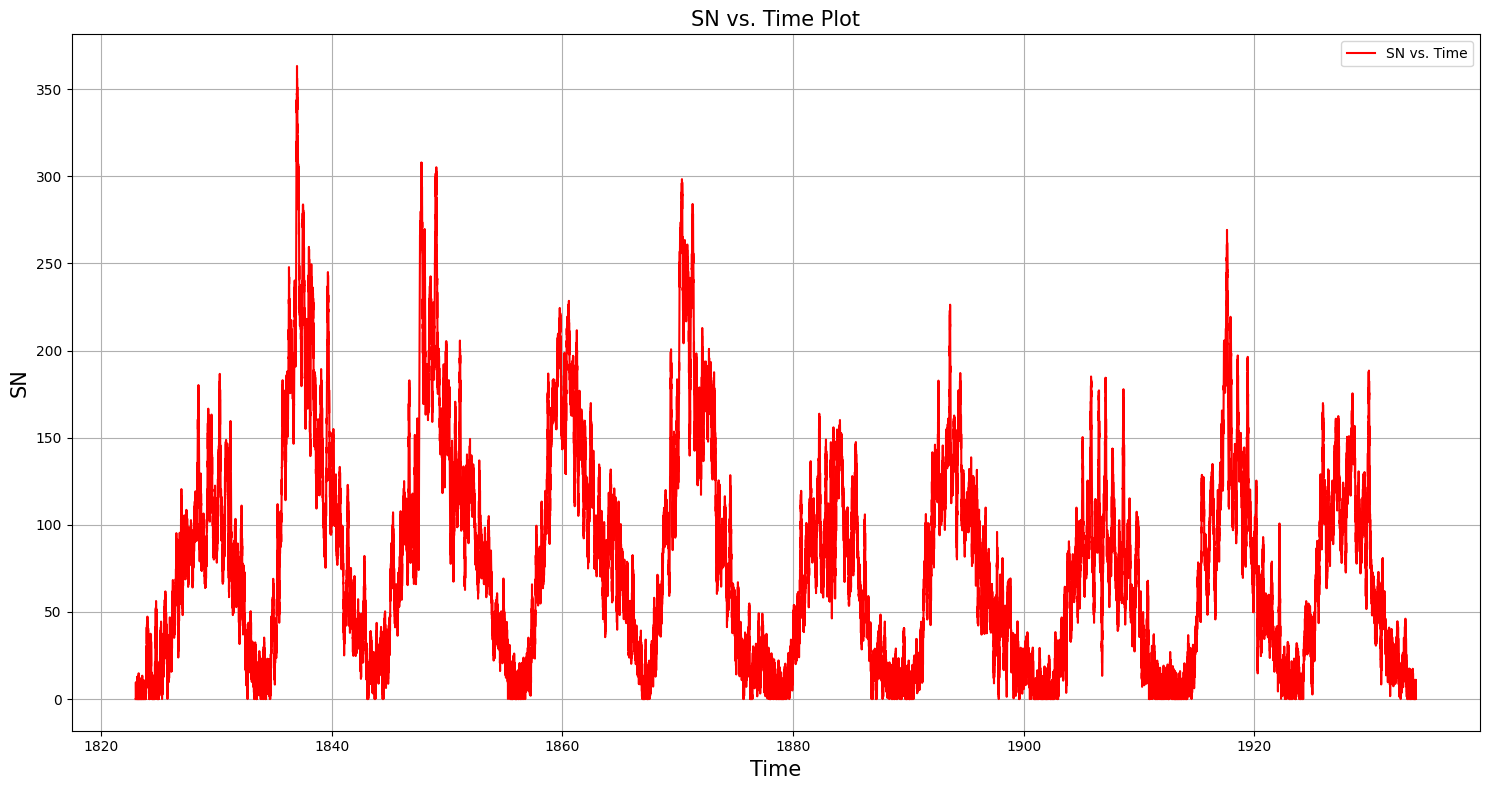

In [8]:
# Plot the data
plt.figure(figsize=(15, 8))
plt.plot(time, sn, linestyle='-', color='r', label='SN vs. Time')

# Customize the plot
plt.title("SN vs. Time Plot", fontsize=15)
plt.xlabel("Time", fontsize=15)
plt.ylabel("SN", fontsize=15)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
# Downsample the data
factor = 10
downsampled_time = time[::factor]
downsampled_sn = sn[::factor]

# Check num values of downsampled data
print('time values: ', downsampled_time.size)
print('sn values: ', downsampled_sn.size)

time values:  3998
sn values:  3998


# Define Model and Cost function

In [10]:
# Define the model function for one solar cycle
def solar_cycle(t, T0_k, Ts_k, Td_k):
    Ts_k = max(Ts_k, 1e-6)  # Avoid division by zero
    Td_k = max(Td_k, 1e-6)  # Avoid division by zero
    return ((t - T0_k) / Ts_k)**2 * np.exp(-((t - T0_k) / Td_k)**2)

# Define the model function for ten solar cycles
def solar_model(t, params):
    if len(params) != 30:
        raise ValueError(f"params must have 30 values, but has {len(params)} values.")
    x = np.zeros_like(t)
    for k in range(10):  # 10 cycles
        T0_k, Ts_k, Td_k = params[3*k:3*k+3]
        if k < 9:  # For cycles 1 to 9
            T0_next = params[3*(k+1)]  # T0 for the next cycle
            mask = (t >= T0_k) & (t < T0_next)  # Time range for this cycle
        else:  # For the 10th cycle
            mask = (t >= T0_k)  # Time range for the last cycle
        x[mask] += solar_cycle(t[mask], T0_k, Ts_k, Td_k)
    return x

# Define the loss function
def mse(params):
    predictions = solar_model(downsampled_time, params)
    return np.mean((downsampled_sn - predictions)**2)

## Simulated Annealing (SA) Algorithm

In [11]:
# Simulated Annealing Algorithm
def simulated_annealing(x0, T0, sigma, f, n_iter=50000, burn_in=40000):
    x = x0.copy()
    T = T0
    n_params = x0.shape[0]
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))
    mse_values = []

    iter_counter = 0
    while iter_counter < n_iter:
        iter_counter += 1
        x_old = x
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)

        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old

        T = T0 * (1 - iter_counter / n_iter)
        mse_values.append(f(x))

    return x, mse_values


# Grid Search über T0 und Sigma (hyperparameter-Optimisation)

In [ ]:
# Startparameter definieren
initial_T0 = [2.2, 5.0, 2.7, 1.5, 5.6, 3.5, 7.7, 3.4, 9.6, 12.2]  # Sonnenzyklus-Minima
initial_Ts = [0.3] * 10  # Standardwerte für Ts
initial_Td = [5.0] * 10  # Standardwerte für Td
x0 = np.array(initial_T0 + initial_Ts + initial_Td)  # Kombinierte Startparameter

# Hyperparameter-Bereich
T0_values = np.arange(15, 25.1, 0.5)  # Wertebereich für T0
sigma_values = np.arange(3, 7.1, 0.5)  # Wertebereich für Sigma

# Parallelisierungsfunktion
def parallel_task(params):
    T0, sigma = params
    print(f"Running simulated annealing with T0={T0}, sigma={sigma}")
    outSA, mse_history = simulated_annealing(x0, T0, sigma, f=mse)
    final_loss = mse(outSA)

    # Plot MSE-Verlauf und speichern
    plt.figure(figsize=(8, 5))
    plt.plot(mse_history)
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title(f"MSE Verlauf für T0={T0}, sigma={sigma}")
    plt.grid()

    output_dir = "mse_plots"
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = f"{output_dir}/mse_T0_{T0}_sigma_{sigma}.png"
    plt.savefig(plot_filename)
    plt.close()

    print(f"Finished T0={T0}, sigma={sigma} -> Final Loss: {final_loss}")
    return (T0, sigma, final_loss)

# Grid Search parallelisieren
if __name__ == "__main__":
    params_list = list(itertools.product(T0_values, sigma_values))  # Kombiniere alle Wertepaare

    with Pool(processes=32) as pool:  # Passe die Anzahl der Prozesse an
        results = pool.map(parallel_task, params_list)

    # Ergebnisse analysieren
    results_dict = {(T0, sigma): loss for T0, sigma, loss in results}
    best_params = min(results_dict, key=results_dict.get)
    print(f"Beste Kombination von T0 und Sigma: {best_params}, Verlust: {results_dict[best_params]}")


```plaintext
Erstelle und aktiviere virtuelle Umgebung...
Installiere benötigte Pakete...
Requirement already satisfied: pip in ./venv/lib/python3.11/site-packages (24.3.1)
Requirement already satisfied: setuptools in ./venv/lib/python3.11/site-packages (75.6.0)
Requirement already satisfied: wheel in ./venv/lib/python3.11/site-packages (0.45.1)
Requirement already satisfied: numpy in ./venv/lib/python3.11/site-packages (2.2.0)
Requirement already satisfied: pandas in ./venv/lib/python3.11/site-packages (2.2.3)
Requirement already satisfied: matplotlib in ./venv/lib/python3.11/site-packages (3.10.0)
Requirement already satisfied: python-dateutil>=2.8.2 in ./venv/lib/python3.11/site-packages (from pandas) (2.9.0.post0)
Requirement already satisfied: pytz>=2020.1 in ./venv/lib/python3.11/site-packages (from pandas) (2024.2)
Requirement already satisfied: tzdata>=2022.7 in ./venv/lib/python3.11/site-packages (from pandas) (2024.2)
Requirement already satisfied: contourpy>=1.0.1 in ./venv/lib/python3.11/site-packages (from matplotlib) (1.3.1)
Requirement already satisfied: cycler>=0.10 in ./venv/lib/python3.11/site-packages (from matplotlib) (0.12.1)
Requirement already satisfied: fonttools>=4.22.0 in ./venv/lib/python3.11/site-packages (from matplotlib) (4.55.3)
Requirement already satisfied: kiwisolver>=1.3.1 in ./venv/lib/python3.11/site-packages (from matplotlib) (1.4.7)
Requirement already satisfied: packaging>=20.0 in ./venv/lib/python3.11/site-packages (from matplotlib) (24.2)
Requirement already satisfied: pillow>=8 in ./venv/lib/python3.11/site-packages (from matplotlib) (11.0.0)
Requirement already satisfied: pyparsing>=2.3.1 in ./venv/lib/python3.11/site-packages (from matplotlib) (3.2.0)
Requirement already satisfied: six>=1.5 in ./venv/lib/python3.11/site-packages (from python-dateutil>=2.8.2->pandas) (1.17.0)
Installierte Pakete:
Package         Version
--------------- -----------
contourpy       1.3.1
cycler          0.12.1
fonttools       4.55.3
kiwisolver      1.4.7
matplotlib      3.10.0
numpy           2.2.0
packaging       24.2
pandas          2.2.3
pillow          11.0.0
pip             24.3.1
pyparsing       3.2.0
python-dateutil 2.9.0.post0
pytz            2024.2
setuptools      75.6.0
six             1.17.0
tzdata          2024.2
wheel           0.45.1
Starte Python-Skript...
Downsampled time values: 3998
Downsampled sn values: 3998
Running simulated annealing with T0=17.0, sigma=5.0
Finished T0=17.0, sigma=5.0 -> Final Loss: 5604.142162144495
Running simulated annealing with T0=17.0, sigma=5.5
Finished T0=17.0, sigma=5.5 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=22.0, sigma=3.0
Finished T0=22.0, sigma=3.0 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=22.0, sigma=3.5
Finished T0=22.0, sigma=3.5 -> Final Loss: 3673.6279163001923
Running simulated annealing with T0=15.0, sigma=6.0
Finished T0=15.0, sigma=6.0 -> Final Loss: 5564.316850264251
Running simulated annealing with T0=15.0, sigma=6.5
Finished T0=15.0, sigma=6.5 -> Final Loss: 5231.629420737861
Running simulated annealing with T0=18.5, sigma=5.5
Finished T0=18.5, sigma=5.5 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=18.5, sigma=6.0
Finished T0=18.5, sigma=6.0 -> Final Loss: 3674.2100284382973
Running simulated annealing with T0=22.0, sigma=6.0
Finished T0=22.0, sigma=6.0 -> Final Loss: 5148.7598692913125
Running simulated annealing with T0=22.0, sigma=6.5
Finished T0=22.0, sigma=6.5 -> Final Loss: 3669.8757876637446
Running simulated annealing with T0=16.0, sigma=6.0
Finished T0=16.0, sigma=6.0 -> Final Loss: 5566.716865777327
Running simulated annealing with T0=16.0, sigma=6.5
Finished T0=16.0, sigma=6.5 -> Final Loss: 5193.19314034908
Running simulated annealing with T0=18.5, sigma=3.5
Finished T0=18.5, sigma=3.5 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=18.5, sigma=4.0
Finished T0=18.5, sigma=4.0 -> Final Loss: 3672.5886745502003
Running simulated annealing with T0=22.0, sigma=5.0
Finished T0=22.0, sigma=5.0 -> Final Loss: 5258.814950521041
Running simulated annealing with T0=22.0, sigma=5.5
Finished T0=22.0, sigma=5.5 -> Final Loss: 3670.1853263259
Running simulated annealing with T0=17.0, sigma=6.0
Finished T0=17.0, sigma=6.0 -> Final Loss: 5592.551466433551
Running simulated annealing with T0=17.0, sigma=6.5
Finished T0=17.0, sigma=6.5 -> Final Loss: 5235.652001487822
Running simulated annealing with T0=21.5, sigma=6.5
Finished T0=21.5, sigma=6.5 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=21.5, sigma=7.0
Finished T0=21.5, sigma=7.0 -> Final Loss: 3676.3491895773245
Running simulated annealing with T0=25.0, sigma=7.0
Finished T0=25.0, sigma=7.0 -> Final Loss: 5093.813866681273
Running simulated annealing with T0=15.0, sigma=4.0
Finished T0=15.0, sigma=4.0 -> Final Loss: 5523.898852042047
Running simulated annealing with T0=15.0, sigma=4.5
Finished T0=15.0, sigma=4.5 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=18.5, sigma=4.5
Finished T0=18.5, sigma=4.5 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=18.5, sigma=5.0
Finished T0=18.5, sigma=5.0 -> Final Loss: 3673.818915280837
Running simulated annealing with T0=22.0, sigma=7.0
Finished T0=22.0, sigma=7.0 -> Final Loss: 5169.628345576867
Running simulated annealing with T0=22.5, sigma=3.0
Finished T0=22.5, sigma=3.0 -> Final Loss: 3670.325697400637
Running simulated annealing with T0=16.5, sigma=3.5
Finished T0=16.5, sigma=3.5 -> Final Loss: 5577.991495734731
Running simulated annealing with T0=16.5, sigma=4.0
Finished T0=16.5, sigma=4.0 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=18.5, sigma=6.5
Finished T0=18.5, sigma=6.5 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=18.5, sigma=7.0
Finished T0=18.5, sigma=7.0 -> Final Loss: 3672.9248443316164
Running simulated annealing with T0=22.0, sigma=4.0
Finished T0=22.0, sigma=4.0 -> Final Loss: 5341.873747323365
Running simulated annealing with T0=22.0, sigma=4.5
Finished T0=22.0, sigma=4.5 -> Final Loss: 3670.2369883513675
Running simulated annealing with T0=15.5, sigma=3.5
Finished T0=15.5, sigma=3.5 -> Final Loss: 5585.206819652646
Running simulated annealing with T0=15.5, sigma=4.0
Finished T0=15.5, sigma=4.0 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=20.0, sigma=7.0
Finished T0=20.0, sigma=7.0 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=20.5, sigma=3.0
Finished T0=20.5, sigma=3.0 -> Final Loss: 3671.7863760600067
Running simulated annealing with T0=22.5, sigma=4.5
Finished T0=22.5, sigma=4.5 -> Final Loss: 5397.884941891661
Running simulated annealing with T0=22.5, sigma=5.0
Finished T0=22.5, sigma=5.0 -> Final Loss: 3670.672276849098
Running simulated annealing with T0=15.5, sigma=6.5
Finished T0=15.5, sigma=6.5 -> Final Loss: 5582.51836866558
Running simulated annealing with T0=15.5, sigma=7.0
Finished T0=15.5, sigma=7.0 -> Final Loss: 5263.178551125147
Running simulated annealing with T0=19.0, sigma=5.0
Finished T0=19.0, sigma=5.0 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=19.0, sigma=5.5
Finished T0=19.0, sigma=5.5 -> Final Loss: 3673.7863365871476
Running simulated annealing with T0=22.5, sigma=6.5
Finished T0=22.5, sigma=6.5 -> Final Loss: 5200.621488359989
Running simulated annealing with T0=22.5, sigma=7.0
Finished T0=22.5, sigma=7.0 -> Final Loss: 3669.9230704189704
Running simulated annealing with T0=18.0, sigma=6.0
Finished T0=18.0, sigma=6.0 -> Final Loss: 5584.465457486646
Running simulated annealing with T0=18.0, sigma=6.5
Finished T0=18.0, sigma=6.5 -> Final Loss: 5280.39185626989
Running simulated annealing with T0=19.5, sigma=5.5
Finished T0=19.5, sigma=5.5 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=19.5, sigma=6.0
Finished T0=19.5, sigma=6.0 -> Final Loss: 3673.1489901239106
Running simulated annealing with T0=24.0, sigma=7.0
Finished T0=24.0, sigma=7.0 -> Final Loss: 5144.103426034794
Running simulated annealing with T0=24.5, sigma=3.0
Finished T0=24.5, sigma=3.0 -> Final Loss: 3670.363972771992
Running simulated annealing with T0=15.5, sigma=5.5
Finished T0=15.5, sigma=5.5 -> Final Loss: 5587.984212903728
Running simulated annealing with T0=15.5, sigma=6.0
Finished T0=15.5, sigma=6.0 -> Final Loss: 5243.733382247882
Running simulated annealing with T0=19.5, sigma=4.5
Finished T0=19.5, sigma=4.5 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=19.5, sigma=5.0
Finished T0=19.5, sigma=5.0 -> Final Loss: 3673.4595463698192
Running simulated annealing with T0=23.0, sigma=3.0
Finished T0=23.0, sigma=3.0 -> Final Loss: 5492.8858665002535
Running simulated annealing with T0=23.0, sigma=3.5
Finished T0=23.0, sigma=3.5 -> Final Loss: 3670.9226135873037
Running simulated annealing with T0=16.5, sigma=4.5
Finished T0=16.5, sigma=4.5 -> Final Loss: 5582.925738830791
Running simulated annealing with T0=16.5, sigma=5.0
Finished T0=16.5, sigma=5.0 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=19.0, sigma=7.0
Finished T0=19.0, sigma=7.0 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=19.5, sigma=3.0
Finished T0=19.5, sigma=3.0 -> Final Loss: 3671.691266964479
Running simulated annealing with T0=23.5, sigma=4.5
Finished T0=23.5, sigma=4.5 -> Final Loss: 5359.148941441688
Running simulated annealing with T0=23.5, sigma=5.0
Finished T0=23.5, sigma=5.0 -> Final Loss: 3670.337273371696
Running simulated annealing with T0=17.5, sigma=5.5
Finished T0=17.5, sigma=5.5 -> Final Loss: 5554.428964330378
Running simulated annealing with T0=17.5, sigma=6.0
Finished T0=17.5, sigma=6.0 -> Final Loss: 5272.201187267528
Running simulated annealing with T0=19.0, sigma=6.0
Finished T0=19.0, sigma=6.0 -> Final Loss: 9674.661327004405
Running simulated annealing with T0=19.0, sigma=6.5
Finished T0=19.0, sigma=6.5 -> Final Loss: 3673.789725474091
Running simulated annealing with T0=22.5, sigma=3.5
Finished T0=22.5, sigma=3.5 -> Final Loss: 5357.114515594417
Running simulated annealing with T0=22.5, sigma=4.0
Finished T0=22.5, sigma=4.0 -> Final Loss: 3670.329430156114
Beste Kombination von T0 und Sigma: (np.float64(23.0), np.float64(6.5)), Verlust: 3669.7140858532844


![Loss Evolution](./mse_T0_23.0_sigma_6.5.png)


## Task 2

In [ ]:
# Funktion für die parallele Optimierung
def parallel_optimization(task_params):
    T0, sigma, x0 = task_params
    optimized_params = simulated_annealing(x0, T0, sigma, mse)
    return optimized_params

# Beste Hyperparameter aus Task 1
best_T0 = XXXXXX  # Beispielwert
best_sigma = XXXXXX  # Beispielwert

# Initialwerte leicht verrauschen
np.random.seed(42)
initial_params = np.array([2.2, 5.0, 2.7, 1.5, 5.6, 3.5, 7.7, 3.4, 9.6, 12.2] + 
                          [0.3]*10 + [5.0]*10)  # Startwerte
noisy_initial_conditions = [initial_params + np.random.normal(0, 0.1, size=30) for _ in range(10)]

# Parallelisierung vorbereiten
task_list = [(best_T0, best_sigma, x0) for x0 in noisy_initial_conditions]

if __name__ == "__main__":
    with Pool(processes=10) as pool:
        optimized_results = pool.map(parallel_optimization, task_list)

    # Ergebnisse sammeln und Center of Mass berechnen
    optimized_array = np.array(optimized_results)
    center_of_mass = np.mean(optimized_array, axis=0)

    print("Optimierte Parameter (Center of Mass):", center_of_mass)

    # Visualisierung
    predictions = solar_model(time, center_of_mass)
    plt.figure(figsize=(10, 6))
    plt.plot(time, sn, label="Original SN Data", color="orange")
    plt.plot(time, predictions, label="Optimized Fit", color="blue")
    plt.xlabel("Year")
    plt.ylabel("SN")
    plt.legend()
    plt.title("Model Calibration (Optimized Fit)")
    plt.grid()
    plt.savefig("optimized_fit.png")
    plt.show()